Задание на кластеризацию, понижение размерности и классификацию.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.colors import ListedColormap

%matplotlib inline


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 17

<ipython-input-1-035516a233cc>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])
<ipython-input-1-035516a233cc>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
X_train = np.loadtxt("/content/samsung_train.txt")
y_train = np.loadtxt("/content/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("/content/samsung_test.txt")
y_test = np.loadtxt("/content/samsung_test_labels.txt").astype(int)

In [4]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [5]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

In [8]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [10]:
RANDOM_STATE = 42

pca = PCA(n_components=0.90, random_state=RANDOM_STATE)

X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [12]:
pca = PCA(random_state=RANDOM_STATE)

X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Минимальное количество главных компонент для объяснения 90% дисперсии: {n_components_90}")

Минимальное количество главных компонент для объяснения 90% дисперсии: 65


Ответ: 65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

In [13]:
pca = PCA(random_state=RANDOM_STATE)

X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
variance_first_component = explained_variance_ratio[0] * 100

variance_first_component = round(variance_first_component)

print(f"Процент дисперсии на первой главной компоненте: {variance_first_component}%")

Процент дисперсии на первой главной компоненте: 51%


Ответ: 51

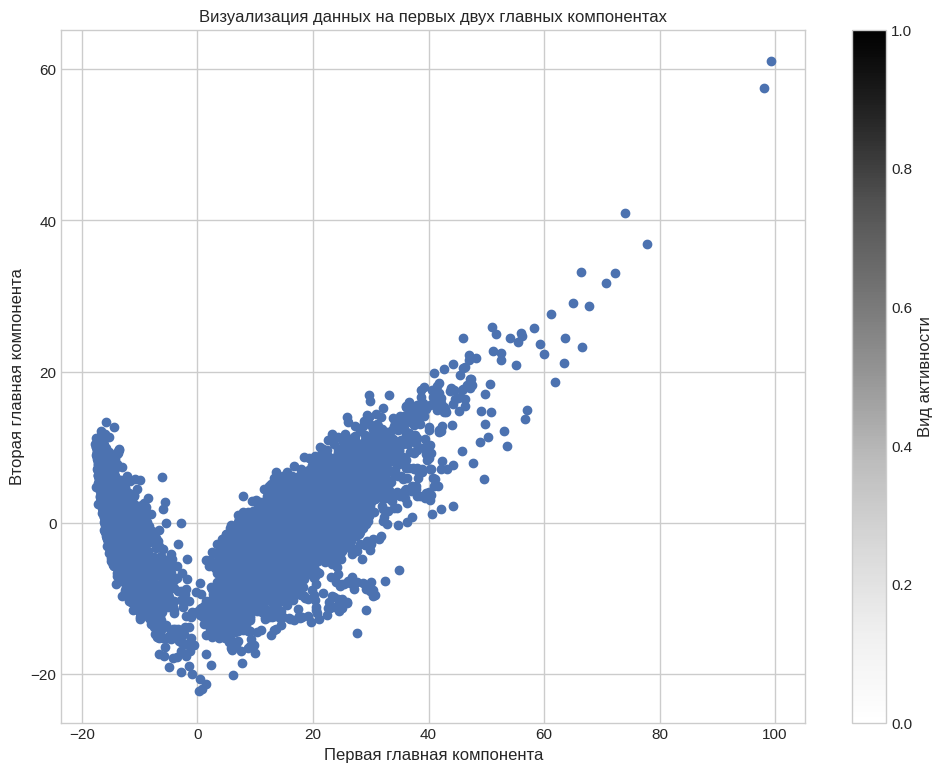

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')
plt.title('Визуализация данных на первых двух главных компонентах')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Вид активности')
plt.show()

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

 **Ответ - 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [17]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)

kmeans.fit(X_pca)

KMeans(n_clusters=6, n_init=100, random_state=42)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

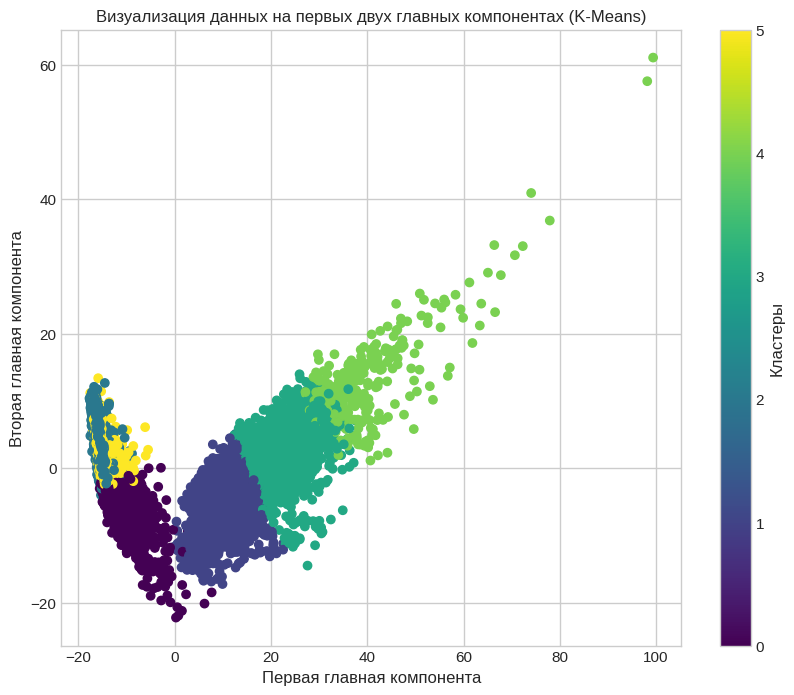

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', c=kmeans.labels_)
plt.title('Визуализация данных на первых двух главных компонентах (K-Means)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Кластеры')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [23]:
import pandas as pd

tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,0,742,77,0,1722
подъем вверх по лестнице,2,1242,0,295,5,0,1544
спуск по лестнице,0,321,0,889,196,0,1406
сидение,451,1,91,0,0,1234,1777
стояние,566,0,0,0,0,1340,1906
лежание,330,5,1556,0,0,53,1944
все,1349,2472,1647,1926,278,2627,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ - перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

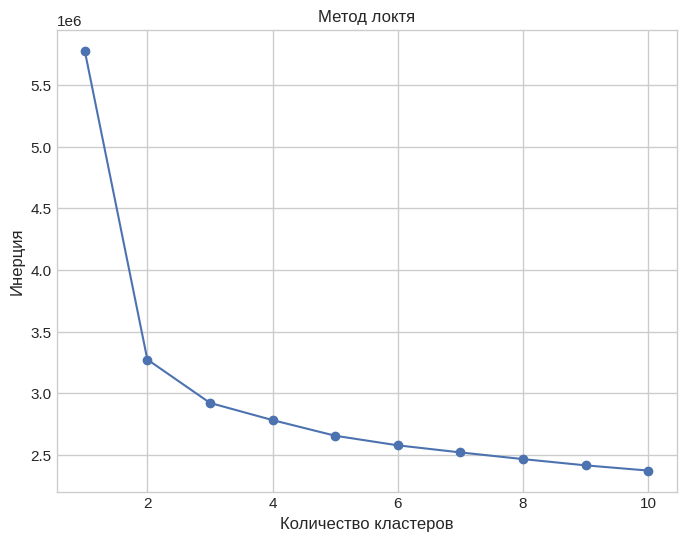

In [24]:
inertia = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

Ответ - 3

In [25]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [26]:
from sklearn.metrics.cluster import adjusted_rand_score

y_ag = ag.fit_predict(X_pca)

kmeans = KMeans(n_clusters = 2, n_init = 100, random_state = RANDOM_STATE)
y_kmeans = kmeans.fit_predict(X_pca)

print(adjusted_rand_score(y_ag, y))
print(adjusted_rand_score(y_kmeans, y))

0.459874890109388
0.3296106738894193


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Ответы:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [28]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}


In [30]:
svm = LinearSVC()
grid_search = GridSearchCV(svm, param_grid, cv=3)


In [31]:
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_['C']


In [32]:
final_svm = LinearSVC(C=best_C)
final_svm.fit(X_train_scaled, y_train)


LinearSVC(C=0.1)

In [33]:
y_pred = final_svm.predict(X_test_scaled)


**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.1

In [34]:
best_C = grid_search.best_params_['C']
print(f"Лучший параметр C: {best_C}")


Лучший параметр C: 0.1


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – сидение, по полноте – стояние

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

svm = LinearSVC()
grid_search = GridSearchCV(svm, param_grid, cv=3)

grid_search.fit(X_train_pca, y_train)

best_C_pca = grid_search.best_params_['C']
print(f"Лучший параметр C с PCA: {best_C_pca}")

final_svm_pca = LinearSVC(C=best_C_pca)
final_svm_pca.fit(X_train_pca, y_train)

y_pred_pca = final_svm_pca.predict(X_test_pca)

Лучший параметр C с PCA: 0.1


**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Ответ**
- Качество одинаковое

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Ответы:**
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком